In [1]:
import numpy as np
import pandas as pd

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.linear_model import LassoCV,RidgeCV

from sklearn import metrics

In [7]:
df = pd.read_csv('laptop_eda.csv')

In [8]:
df

,Company,Type,OpSys,CPU,GPU,Ram,Weight,Touchscreen,ClockSpeed,HDD,SSD,PPI,Price
0,Apple,Ultrabook,Mac,Intel,Intel,8,1.37,0,2.3,0.0,0.128,312.781955,71378.6832
1,Apple,Ultrabook,Mac,Intel,Intel,8,1.34,0,1.8,0.0,0.000,175.939850,47895.5232
2,HP,Notebook,No,Intel,Intel,8,1.86,0,2.5,0.0,0.256,192.307692,30636.0000
3,Apple,Ultrabook,Mac,Intel,AMD,16,1.83,0,2.7,0.0,0.512,303.896104,135195.3360
4,Apple,Ultrabook,Mac,Intel,Intel,8,1.37,0,3.1,0.0,0.256,312.781955,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,Lenovo,2 in 1 Convertible,Windows,Intel,Intel,4,1.80,1,2.5,0.0,0.128,214.285714,33992.6400
1296,Lenovo,2 in 1 Convertible,Windows,Intel,Intel,16,1.30,1,2.5,0.0,0.512,375.939850,79866.7200
1297,Lenovo,Notebook,Windows,Intel,Intel,2,1.50,0,1.6,0.0,0.000,152.428571,12201.1200
1298,HP,Notebook,Windows,Intel,AMD,6,2.19,0,2.5,1.0,0.000,136.794872,40705.9200


In [17]:
x = df.iloc[:,:-1]
y = pd.DataFrame(df['Price'])
y = np.log(y)

In [14]:
ct = ColumnTransformer(transformers=[('clm_tns',OneHotEncoder(drop='first'),[i for i in range(5)])], remainder='passthrough')

In [15]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('clm_tns', OneHotEncoder(drop='first'),
                                 [0, 1, 2, 3, 4])])

In [18]:
x = ct.fit_transform(x)

In [21]:
y

,Price
0,11.175755
1,10.776777
2,10.329931
3,11.814476
4,11.473101
...,...
1295,10.433899
1296,11.288115
1297,9.409283
1298,10.614129


In [20]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.15,random_state=5)

In [22]:
std = StandardScaler()
std.fit(x_train)
std_x_train = std.transform(x_train)
std_x_test = std.transform(x_test)

In [23]:
lr = LinearRegression()
lr.fit(std_x_train,y_train)

LinearRegression()

In [24]:
def evaluation(x_test, y_test,model) :
    
    y_pred = model.predict(x_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    msqe = metrics.mean_squared_error(y_test, y_pred)
    r2_score = metrics.r2_score(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    return {'mae':mae,'msqe':msqe,'r2_score':r2_score,'rmse':rmse}

In [25]:
ev = pd.DataFrame(evaluation(std_x_test,y_test,lr),index=['Linear',]).T
ev

,Linear
mae,0.210726
msqe,0.074495
r2_score,0.800483
rmse,0.272938


In [26]:
l1 = Lasso()
l1.fit(std_x_train,y_train)

Lasso()

In [27]:
a = evaluation(std_x_test,y_test,l1)
ev['lasso'] = [*a.values()]
# ev['lasso'] = ev[].apply(lambda x: '{:.2f}'.format(x))
ev

,Linear,lasso
mae,0.210726,0.501214
msqe,0.074495,0.381030
r2_score,0.800483,-0.020491
rmse,0.272938,0.617276


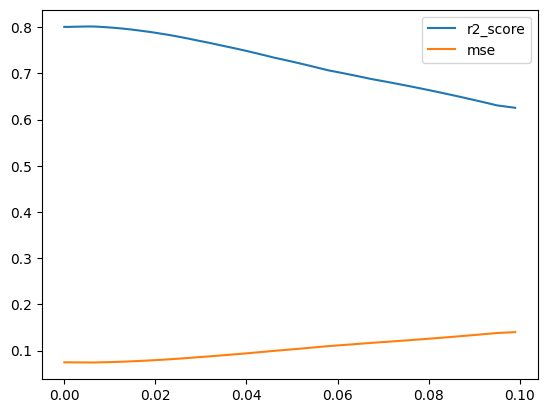

In [28]:
r2 = {}
mse = {}
alpha = np.arange(0.00001, 0.1, 0.001) 
for i in alpha:
    
    l1 = Lasso(alpha=i)
    l1.fit(std_x_train,y_train)
    y_pred = l1.predict(std_x_test)
    r2[i] = metrics.r2_score(y_test, y_pred)
    mse[i] = metrics.mean_squared_error(y_test,y_pred)
plt.plot(r2.keys(),r2.values())
plt.plot(mse.keys(),mse.values())
plt.legend(['r2_score','mse'])

In [29]:
alpha = alpha = np.arange(0.00001, 0.1, 0.001) 
l1cv = LassoCV(alphas=alpha)
l1cv.fit(std_x_train,y_train)
best_alpha = l1cv.alpha_

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
best_alpha

0.00201

In [31]:
l1 = Lasso(alpha=best_alpha)
l1.fit(std_x_train,y_train)

Lasso(alpha=0.00201)

In [32]:
a = evaluation(std_x_test,y_test,l1)
ev['lasso-aplha=0.00201 cv=0'] = [*a.values()]
# ev['lasso'] = ev[].apply(lambda x: '{:.2f}'.format(x))
ev

,Linear,lasso,lasso-aplha=0.00201 cv=0
mae,0.210726,0.501214,0.210942
msqe,0.074495,0.381030,0.074390
r2_score,0.800483,-0.020491,0.800764
rmse,0.272938,0.617276,0.272746


In [33]:
alpha = alpha = np.arange(0.00001, 0.1, 0.001) 
l1cv = LassoCV(alphas=alpha,cv=5)
l1cv.fit(std_x_train,y_train)
best_alpha = l1cv.alpha_
best_alpha

c:\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.00201